# Light Curve Classifier
***

## Learning Goals
By the end of this tutorial, you will be able to:
- do some basic data cleaning and filtering to prepare the data for the ML algorithms
- work with Pandas data frames as a way of storing time domain datasets
- use sktime algorithms to train a classifier and predict values on a test dataset

## Introduction
This notebook takes output of a previous demo notebook which generates light curves from archival data, does data prep, and runs the light curves through multiple [`sktime`](https://www.sktime.net/en/stable/) classifiers.  The goal of the classifiers is to be able to differentiate changing look active galactic nucleii (CLAGN) from an SDSS quasar sample based on multiband light curves.  CLAGN are quite interested objects in that they appear to change state, but only a few hundred are currently known, and finding them is quite expensive requiring spectroscopic follow up.  Being able to identify CLAGN in existing large samples would allow us to identify a statisitcal sample from which we could better understand the physics of what is occuring in these systems.

The challenges of this time-domain dataset are:
1. Multi-variate = There are multiple bands of observations per target (13+)
2. Unequal length = Each band has a light curve with different sampling than other bands
3. Missing data = Not each object has all observations in all bands

We choose to use a Pandas multiindex dataframe to store and work with the data because it fulfills these requirements:
1. It can handle the above challenges of a dataset = multi-variate, unqueal length with missing data.
2. Multiple targets (multiple rows)
3. Pandas has some built in understanding of time units
4. Can be scaled up to big data numbers of rows (altough we don't push to out of memory structures in this use case)
5. Pandas is user friendly


## Input
Light curve parquet file of multiband light curves from the mulitband_lc.ipynb demo notebook.  The format of the light curves is a Pandas multiindex data frame

A useful reference for what sktime expects as input to its ML algorithms: https://github.com/sktime/sktime/blob/main/examples/AA_datatypes_and_datasets.ipynb

## Output
Trained classifiers as well as estimates of their accuracy and plots of confusion matrices

## Imports
- `pandas` to work with light curve data structure
- `numpy` for numerical calculations
- `matplotlib` for plotting
- `sys` for paths
- `astropy` to work with coordinates/units and data structures
- `tqdm` for showing progress meter
- `sktime` ML algorithms specifically for time-domain data
- `sklearn` general use ML algorthims with easy to use interface

## Authors

## Acknowledgements

In [ ]:
#ensure all dependencies are installed
!pip install -r requirements-lc_classifier.txt

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.time import Time
from google_drive_downloader import GoogleDriveDownloader as gdd
from scipy.stats import sigmaclip

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsRegressor

from sktime.classification.deep_learning import CNNClassifier
from sktime.classification.dictionary_based import IndividualTDE
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.dummy import DummyClassifier
from sktime.classification.ensemble import WeightedEnsembleClassifier
from sktime.classification.feature_based import Catch22Classifier, RandomIntervalClassifier
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.interval_based import CanonicalIntervalForest
from sktime.classification.kernel_based import Arsenal, RocketClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.registry import all_estimators, all_tags
from tqdm import tqdm

# local code imports
sys.path.append('code_src/')
from fluxconversions import mjd_to_jd

## 1. Read in a dataset of archival light curves

In [2]:
#access structure of light curves made in the light curve notebook
# has CLAGN & SDSS small sample, all bands
#https://drive.google.com/file/d/13RiPODiz2kI8j1OKpP1vfh6ByIUNsKEz/view?usp=share_link

gdd.download_file_from_google_drive(file_id='13RiPODiz2kI8j1OKpP1vfh6ByIUNsKEz',
                                    dest_path='./data/df_lc_458sample.parquet',
                                    unzip=True)

df_lc = pd.read_parquet("./data/df_lc_458sample.parquet")

#get rid of indices set in the light curve code and reset them as needed before sktime algorithms
df_lc = df_lc.reset_index()  

## 2. Data Prep
This dataset needs significant work before it can be fed into a ML algorithm

In [3]:
#what does the dataset look like anyway?
df_lc

,objectid,label,band,time,flux,err
0,112,Lopez-Navas 22,FERMIGTRIG,56371.813768,0.100000,0.100000
1,218,SDSS,FERMIGTRIG,59568.171278,0.100000,0.100000
2,395,SDSS,FERMIGTRIG,54699.331556,0.100000,0.100000
3,414,SDSS,FERMIGTRIG,56369.455916,0.100000,0.100000
4,434,SDSS,FERMIGTRIG,58941.402522,0.100000,0.100000
...,...,...,...,...,...,...
426627,183,SDSS,w2,55230.410156,6.717855,0.019561
426628,183,SDSS,w2,57054.886719,6.715584,0.023281
426629,183,SDSS,w2,57247.308594,7.572342,0.024136
426630,183,SDSS,w2,57977.214844,7.876407,0.023734


### 2.1 Remove bands with not enough data

In [4]:
##what are the unique set of bands included in our light curves
df_lc.band.unique()

array(['FERMIGTRIG', 'IceCube', 'zg', 'zr', 'zi', 'panstarrs i',
       'panstarrs y', 'panstarrs z', 'panstarrs g', 'panstarrs r',
       'Gaia g', 'Gaia bp', 'Gaia rp', 'K2', 'TESS', 'w1', 'w2'],
      dtype=object)

In [5]:
## get rid of some of the bands that don't have enough data for all the sources
bands_to_drop = ["IceCube", "TESS", "FERMIGTRIG", "K2"]
df_lc = df_lc[~df_lc["band"].isin(bands_to_drop)]


### 2.2 Combine Labels for a Simpler Classification
All CLAGN start in the dataset as having labels based on their discovery paper.  Because we want one sample with all known CLAGN, change those discoery names to be simply "CLAGN" for all CLAGN, regardless of origin

In [6]:

df_lc['label'] = df_lc.label.str.replace('MacLeod 16', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('LaMassa 15', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Yang 18', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Lyu 21', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Hon 22', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Sheng 20', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('MacLeod 19', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Green 22', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Lopez-Navas 22', 'CLAGN')



/tmp/ipykernel_3141/2260488855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['label'] = df_lc.label.str.replace('MacLeod 16', 'CLAGN')
/tmp/ipykernel_3141/2260488855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['label'] = df_lc.label.str.replace('LaMassa 15', 'CLAGN')
/tmp/ipykernel_3141/2260488855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

### 2.3 Remove some rows based on filtering out bad data

In [7]:
#find and drop bad rows

#one panstarrs z has a crazy err value of -999000, definitely don't want to include that one
querystring = 'err < -100'
df_lc = df_lc.drop(df_lc.query(querystring).index)

#drop rows which have Nans
df_lc.dropna(inplace = True, axis = 0)

#drop ~8 rows with zero flux
#We are going to define zero flux later to be missing data, but not sure what these are
querystring = 'flux < 0.000001'
df_lc = df_lc.drop(df_lc.query(querystring).index)



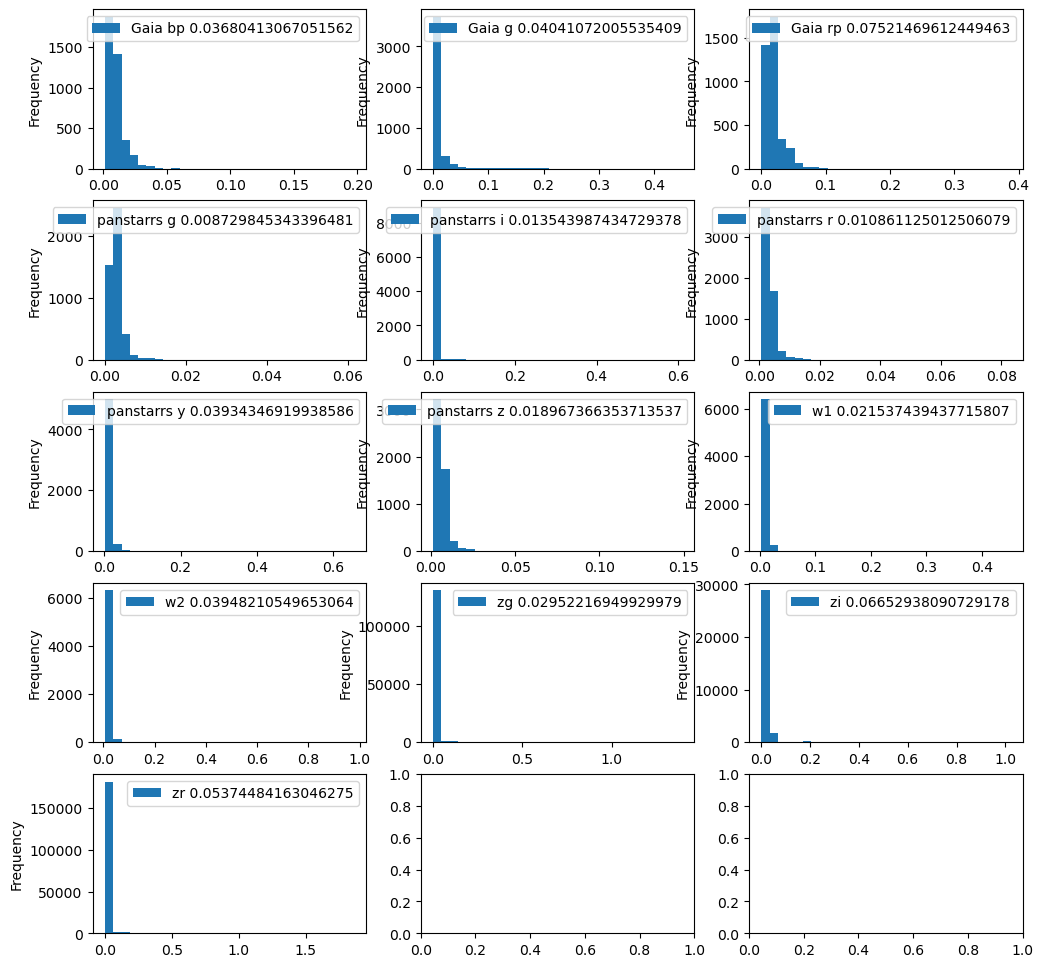

In [8]:
#consider Removing all rows with Signal to noise ratios outside of a normal distribution
#plot histograms to see what these distributions look like

#keep track of how many rows this removes
start_len = len(df_lc)

#first need a Signal to noise ratio column
df_lc["SNR"] = df_lc.flux / df_lc.err

#setup to collect the outlier thresholds
threesigmaonmean= {}

#create the figure and axes
fig, axs = plt.subplots(5, 3, figsize = (12, 12))
# unpack all the axes subplots
axe = axs.ravel()

#for each band
for count, (bandname, singleband) in enumerate(df_lc.groupby("band")):
    clippedarr, lower, upper = sigmaclip(singleband.err, low = 5.0, high = 5.0)
    threesigmaonmean[bandname] = upper
    #plot distributions and print stddev
    singleband.err.plot(kind = 'hist', bins = 30, subplots =True, ax = axe[count],label = bandname+' '+str(upper), legend=True)



In [9]:
#3sigma looks by eye like a reasonable cut for all distributions
#make it so
for bandname, cut in threesigmaonmean.items():
    querystring = f'band == {bandname!r} & err > {cut}'
    print(querystring)
    df_lc = df_lc.drop(df_lc.query(querystring).index)

band == 'Gaia bp' & err > 0.03680413067051562
band == 'Gaia g' & err > 0.04041072005535409
band == 'Gaia rp' & err > 0.07521469612449463
band == 'panstarrs g' & err > 0.008729845343396481
band == 'panstarrs i' & err > 0.013543987434729378
band == 'panstarrs r' & err > 0.010861125012506079
band == 'panstarrs y' & err > 0.03934346919938586
band == 'panstarrs z' & err > 0.018967366353713537
band == 'w1' & err > 0.021537439437715807
band == 'w2' & err > 0.03948210549653064
band == 'zg' & err > 0.02952216949929979
band == 'zi' & err > 0.06652938090729178
band == 'zr' & err > 0.05374484163046275


In [10]:
end_len = len(df_lc)
fraction = (start_len - end_len) / start_len
print(f"This sigma clipping removed {fraction}% of the rows in df_lc")

This sigma clipping removed 0.02727432129071453% of the rows in df_lc


### 2.4 What to do with missing data?
Some objects do not have light curves in all bands, what do we do about that?  Some ML algorithms can handle mising data, but not all. 

Some objects have only a few datapoints.  Three data points is not a large enough for outlier rejection, so we will consider any array with fewer than 4 photometry points to be missing data.

Decide to add light curves with zero flux and err values for the missing data.  SKtime does not like NaNs



In [11]:
def make_zero_df(oid, band, label):
    timelist = [55230,57054, 57247, 57977, 58707]  #making this up for now from some WISE times
    dfsingle = pd.DataFrame(dict(flux=np.zeros(len(timelist)), err=np.zeros(len(timelist)), 
                                 time=timelist, objectid=np.repeat(oid, len(timelist)), 
                                 band=np.repeat(band, len(timelist)),label=np.repeat(label, len(timelist))))


    return dfsingle


In [12]:
#what is the full set of unique band names?
full_bandname = df_lc.band.unique()

#for the case where there is no photometry in a band:
#for each object in each band
for oid , singleoid in df_lc.groupby("objectid"):
                                  
    #this is the list of bandnames for that object                                
    oid_bandname = singleoid.band.unique()
    
    #figure out which bands are missing
    missing = list(set(full_bandname).difference(oid_bandname))
    
    #if it is not the complete list, ie some bandnames are missing:                            
    if len(missing) > 0:
    
        #make new dataframe for this object with zero flux and err values
        for m in range(len(missing)):
            label = singleoid.label.unique()
            dfsingle = make_zero_df(oid, missing[m], label)
            
            #now concatenate the single new df with df_lc
            df_lc = pd.concat([df_lc, dfsingle])

            
#and now for the case that the band is there but has too few datapoints:
thresh_too_few = 4
for (band,oid) , singleband_oid in df_lc.groupby(["band", "objectid"]):
    #if there are less than 4 photometry points
    if len(singleband_oid.time) < thresh_too_few:
        label = singleband_oid.label.unique()
        dfsingle = make_zero_df(oid, band, label)
        
        #now concatenate the single new df with df_lc
        df_lc = pd.concat([df_lc, dfsingle])


### 2.5 Make a new time column with datetime data type 
We need the times in python [datetime](https://docs.python.org/3/library/datetime.html) format for the next section where we will make the light curves be of uniform length. 

Once the time column is in datetime format, make it the time index

In [13]:
#need to convert df_lc time into datetime
mjd = df_lc.time

#convert to JD
jd = mjd_to_jd(mjd)

#convert to individual components
t = Time(jd, format = 'jd' )

#t.datetime is now an array of type datetime
#make it a column in the dataframe
df_lc['datetime'] = t.datetime



### 2.5  Make all objects and bands have identical time arrays (uniform length and spacing)

It is very hard to find time-domain ML algorithms which can handle non uniform length datasets. Therefore we make them uniform using Pandas [reindex](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html) which fills in the uniform length arrays with values according to the method chosen by the user.  We implement a nearest neighbor to fill the arrays.  

Fluxes with missing data are set to zero.  Zero was chosen instead of 'None' or 'Nan' as it was better integrated with the ML algorithms.  

Potential other options for uniformizing the time series dataset:
- pandas.dataframe.interpolate with many methods

In [14]:
df_lc

,objectid,label,band,time,flux,err,SNR,datetime
1379,92,CLAGN,zg,58202.309236,0.736736,0.010347,71.205117,2018-03-25 07:25:17.999035
1380,92,CLAGN,zg,58202.314560,0.730595,0.010290,70.997201,2018-03-25 07:32:58.001288
1381,92,CLAGN,zg,58205.302651,0.658396,0.009634,68.338054,2018-03-28 07:15:49.003208
1382,92,CLAGN,zg,58205.320949,0.681111,0.009840,69.219502,2018-03-28 07:42:10.002236
1383,92,CLAGN,zg,58208.357257,0.589205,0.009014,65.364659,2018-03-31 08:34:26.996165
...,...,...,...,...,...,...,...,...
0,250,SDSS,zr,55230.000000,0.000000,0.000000,NaN,2010-02-03 00:00:00.000000
1,250,SDSS,zr,57054.000000,0.000000,0.000000,NaN,2015-02-01 00:00:00.000000
2,250,SDSS,zr,57247.000000,0.000000,0.000000,NaN,2015-08-13 00:00:00.000000
3,250,SDSS,zr,57977.000000,0.000000,0.000000,NaN,2017-08-12 00:00:00.000000


CPU times: user 1min 43s, sys: 756 ms, total: 1min 44s
Wall time: 11.8 s


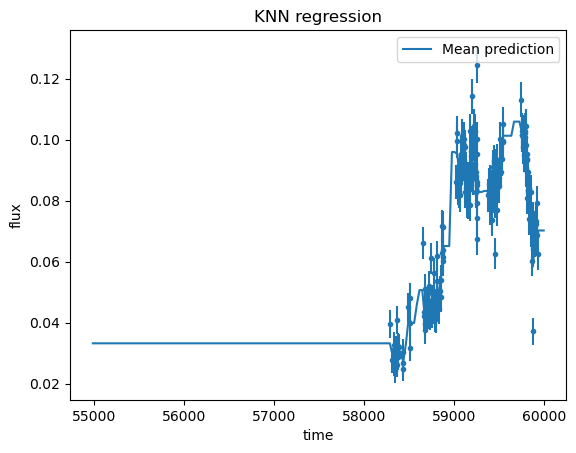

In [23]:
%%time
#try a sklearn regressor to fit the shape of the light curve and do interpolation
#make a time array with the minimum and maximum of all light curves in the sample
final_freq_int = 30  #this is the timescale of interpolation
x_interpol = np.arange(df_lc.time.min(), df_lc.time.max(), final_freq_int)
x_interpol = x_interpol.reshape(-1, 1) # needed for sklearn
lc_interpol = []  # list to store interpolated light curves

#look at each object in each band
for (band,oid) , singleband_oid in df_lc.groupby(["band", "objectid"]):
    #singleband_oid is now a dataframe with just one object and one band
    
    X = np.array(singleband_oid["time"]).reshape(-1, 1)
    y = np.array(singleband_oid["flux"])
    dy = np.array(singleband_oid["err"])
    
    #kernel = 1.0 * RBF(length_scale=30)
    #gp = GaussianProcessRegressor(kernel=kernel, alpha=dy**2, normalize_y = False)
    #gp.fit(X, y)
    #mean_prediction,std_prediction = gp.predict(x_interpol, return_std=True)

    #try KNN
    KNN = KNeighborsRegressor(n_neighbors = 3)
    KNN.fit(X, y)
    mean_prediction = KNN.predict(x_interpol)
        
    #KNN doesnt output an uncertainty array, so make our own:
    #an array of the same length as mean_prediction
    #having values equal to the mean of the original uncertainty array
    err = np.full_like(mean_prediction, singleband_oid.err.mean())  
    
    #get these values into the dataframe
    # append the results as a dict. the list will be converted to a dataframe later.
    lc_interpol.append(
        {"objectid": oid, "label": singleband_oid.label.unique().squeeze(), "band": band, "time": x_interpol.reshape(-1), 
         "flux": mean_prediction, "err": err}
    )
    
        
    #se what this looks like on just a single light curve for now
    if (band == 'zr') and (oid == 9) :  
        #see if this looks reasonable
        plt.errorbar(X,y,dy,linestyle="None",color="tab:blue",marker=".")
        plt.plot(x_interpol, mean_prediction, label="Mean prediction")
        #plt.fill_between(
        #    x_interpol.ravel(),
        #    mean_prediction - 1.96 * std_prediction,
        #    mean_prediction + 1.96 * std_prediction,
        #    color="tab:orange",
        #    alpha=0.5,
        #    label=r"95% confidence interval",
        #)
        plt.legend()
        plt.xlabel("time")
        plt.ylabel("flux")
        _ = plt.title("KNN regression")
        
        
# create a dataframe of the interpolated light curves
df_lc_interpol = pd.DataFrame(lc_interpol)
# df_lc_interpol has one row per dict in lc_interpol. time and flux columns store arrays.
# "explode" the dataframe to get one row per light curve point. time and flux columns will now store floats.
df_lc_interpol = df_lc_interpol.explode(["time", "flux","err"], ignore_index=True)

In [24]:
df_lc_interpol

,objectid,label,band,time,flux,err
0,0,CLAGN,Gaia bp,54985.275796,0.0,0.000668
1,0,CLAGN,Gaia bp,55015.275796,0.0,0.000668
2,0,CLAGN,Gaia bp,55045.275796,0.0,0.000668
3,0,CLAGN,Gaia bp,55075.275796,0.0,0.000668
4,0,CLAGN,Gaia bp,55105.275796,0.0,0.000668
...,...,...,...,...,...,...
982795,457,SDSS,zr,59875.275796,0.830931,0.013213
982796,457,SDSS,zr,59905.275796,0.830027,0.013213
982797,457,SDSS,zr,59935.275796,0.741216,0.013213
982798,457,SDSS,zr,59965.275796,0.813474,0.013213


In [25]:
#need to consider naming scheme better
df_reindex = df_lc_interpol

### 2.6  Restructure dataframe in format expected by sktime
- Make columns have band names in them and then remove band from the index
- pivot the dataframe so that SKTIME understands its format

In [26]:
pivoted_df_reindex = df_reindex.reset_index(level="band").pivot(columns="band")
pivoted_df_reindex.columns = ["_".join(col) for col in pivoted_df_reindex.columns.values]

KeyError: 'Requested level (band) does not match index name (None)'

In [ ]:
pivoted_df_reindex

### 2.7 Normalize to the mean of each objectid
- this is normalizing across all bands
- think this is the right place to do this, rather than before we reindex over time 
    so that the final light curves are normalized since that is the chunk of information 
    which goes into the ML algorithms.
- chose max and not median or mean because there are some objects where the median flux = 0.0
    - if we did this before the reindexing, the median might be a non-zero value
- normalizing is required so that the CLAGN and it's comparison SDSS sample don't have different flux levels.


Idea here is that we normalize across each object.  So the algorithms will know for example that within one object W1 will be brighter than ZTF bands but from one object to the next, it will not know that one is brighter than the other.

In [ ]:
# make a new column with max_r_flux for each objectid
pivoted_df_reindex['max_zr'] = pivoted_df_reindex.groupby('objectid', sort=False)["flux_zr"].transform('max')

#figure out which columns in the dataframe are flux columns
flux_cols = [col for col in pivoted_df_reindex.columns if 'flux' in col]

# make new normalized flux columns for all fluxes
pivoted_df_reinde[flux_cols] = pivoted_df_reindex[flux_cols].div(pivoted_df_reinde['max_zr'], axis=0)

### 2.8 Save this dataframe

In [ ]:
#save this dataframe to use for the ML below so we don't have to make it every time
parquet_savename = 'output/df_ML_091523.parquet'
pivoted_df_reindex.to_parquet(parquet_savename)
#print("file saved!")

In [ ]:
# could load a previously saved file in order to plot
#parquet_loadname = 'output/df_ML_091523.parquet'
#pivoted_df_reindex = MultiIndexDFObject()
#pivoted_df_reindex.data = pd.read_parquet(parquet_loadname)
#print("file loaded!")

## 3. Prep for ML algorithms in sktime



### 3.0 Consider data augmentation

1. https://arxiv.org/pdf/1811.08295.pdf which has the following github

    - https://github.com/gioramponi/GAN_Time_Series/tree/master
    - not easily usable
2. https://arxiv.org/pdf/2205.06758.pdf

3. ChatGPT - give multiindex df function and it will give a starting point for augmenting


Worried that augmenting noisy data just makes more noise


### 3.1 Train test split 
- Because thre are uneven numbers of each type (many more SDSS than CLAGN), we want to make sure to stratify evenly by type
- Random split


In [ ]:
#y is defined to be the labels
y = pivoted_df_reindex.droplevel('datetime').index.unique().get_level_values('label').to_series()

#want a stratified split based on label
train_ix, test_ix = train_test_split(pivoted_df_reindex.index.levels[0], stratify = y, shuffle = True, random_state = 43, test_size = 0.25)

train_df = pivoted_df_reindex.loc[train_ix]  
test_df = pivoted_df_reindex.loc[test_ix]   


In [ ]:
#what does it look like?
train_df

In [ ]:
#plot to show how many of each type of object in the test dataset

plt.figure(figsize=(6,4))
plt.title("Objects in the Test dataset")
h = plt.hist(test_df.droplevel('datetime').index.unique().get_level_values('label').to_series(),histtype='stepfilled',orientation='horizontal')


### 3.2 Convert df_lc into X and y

In [ ]:
#divide the dataframe into X and y for ML algorithms 

#X is the multiindex light curve without the labels
X_train  = train_df.droplevel('label')
X_test = test_df.droplevel('label')

#y are the labels, should be a series 
y_train = train_df.droplevel('datetime').index.unique().get_level_values('label').to_series()
y_test = test_df.droplevel('datetime').index.unique().get_level_values('label').to_series()



### 3.3 Check that the data types are ok for sktime

In [ ]:
#ask sktime if it likes the data type of X
from sktime.datatypes import check_is_mtype

check_is_mtype(X_train, mtype="pd-multiindex", scitype="Panel", return_metadata=True)
#check_is_mtype(X_test, mtype="pd-multiindex", scitype="Panel", return_metadata=True)

## 4. Run Machine Learning Algorithms on the light curves

We choose to use [sktime](https://www.sktime.net/en/stable/index.html) algorithms beacuse it is a library of many algorithms specifically tailored to time series datasets.  It is based on the sklearn library so syntax is familiar to many users.

Types of classifiers are listed [here](https://www.sktime.net/en/stable/api_reference/classification.html).

This notebook will invert the actual workflow and show you a single example of the algorithm which best fits the data and has the most accurate classifier. Then it will show how to write a for loop over a bunch of classifiers before narrowing it down to the most accurate.



In [ ]:
#what is the list of all possible classifiers that work with multivariate data
#all_tags(estimator_types = 'classifier')
classifiers = all_estimators("classifier", filter_tags={'capability:multivariate':True})
classifiers


### 4.1 The Most Accurate Classifier
See section 4.2 for how we landed with this algorithm


In [ ]:
#looks like RandomIntervalClassifier is performing the best for the CLAGN (not for the SDSS)

#setup the classifier
clf = RandomIntervalClassifier(n_intervals = 20, n_jobs = -1, random_state = 43)

#fit the classifier on the training dataset
clf.fit(X_train, y_train)

#make predictions on the test dataset using the trained model 
y_pred = clf.predict(X_test)

print(f"Accuracy of Random Interval Classifier: {accuracy_score(y_test, y_pred)}\n", flush=True)

#plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
    
plt.show()

### 4.2 Loop over a bunch of classifiers

Our method is to do a cursory check of a bunch of classifiers and then later drill down deeper on anything with good initial results.  We choose to run a loop over ~10 classifiers that seem promising and check the accuracy scores for each one.  Any classifier with a promising accuracy score could then be followed up with detailed hyperparameter tuning, or potentially with considering other classifiers in that same type.

In [ ]:
#which classifiers are we interestd in
#roughly one from each type of classifier

names = ["Arsenal",                     #kernel based
        "RocektClassifier",             #kernel based
        "CanonicalIntervalForest",      #interval based
        "HIVECOTEV2",                   #hybrid
#        "CNNClassifier",               #Deep Learning  - **requires tensorflow which is giving import errors
#        "WeightedEnsembleClassifier",   #Ensemble - **maybe use in the future if we find good options
        "IndividualTDE",               #Dictionary-based
        "KNeighborsTimeSeriesClassifier", #Distance Based
        "RandomIntervalClassifier",     #Feature based
        "Catch22Classifier",            #Feature based
        "ShapeletTransformClassifier"   #Shapelet based
        "DummyClassifier"]             #Dummy - ignores input

#for those with an impossible time limit, how long to let them run for before cutting off
nmins = 10

#these could certainly be more tailored
classifier_call = [Arsenal(time_limit_in_minutes=nmins, n_jobs = -1), 
                  RocketClassifier(num_kernels=2000),
                  CanonicalIntervalForest(n_jobs = -1),
                  HIVECOTEV2(time_limit_in_minutes=nmins, n_jobs = -1),
#                  CNNClassifier(),
#                  WeightedEnsembleClassifier(),
                  IndividualTDE(n_jobs=-1),
                  KNeighborsTimeSeriesClassifier(n_jobs = -1),
                  RandomIntervalClassifier(n_intervals = 20, n_jobs = -1, random_state = 43),
                  Catch22Classifier(outlier_norm = True, n_jobs = -1, random_state = 43),
                  ShapeletTransformClassifier(time_limit_in_minutes=nmins,n_jobs = -1),
                  DummyClassifier()]

#setup to store the accuracy scores
accscore_dict = {}

# iterate over classifiers
for name, clf in tqdm(zip(names, classifier_call)):
    #fit the classifier
    clf.fit(X_train, y_train)
    
    #make predictions on the test dataset
    y_pred = clf.predict(X_test)

    #calculate and track accuracy score
    accscore = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {name} classifier: {accscore}\n", flush=True)
    accscore_dict[name] = accscore
    
    #plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.show()

#just for keeping track, I also tried 
#clf = SignatureClassifier(depth = 2, window_depth = 3, random_state = 43)
#this fails to complete, and is a known limitation of this algorithm.  

In [ ]:
#show the summary of the algorithms used and their accuracy score
accscore_dict

## 5.0 Conclusions:  
This classifier can be used to predict CLAGN.  The feature based algorithms do the best jobs of having little to no predicted CLAGN that are truly normal SDSS quasars.  We infer then that if the trained model predicts CLAGN, it is a very good target for follow-up spectroscopy to confirm CLAGN.  However this algorthim will not catch all CLAGN, and will incorrectly labels some CLAGN as being normal SDSS quasars.  THis algorithm can therefore not be used to find a complete sample of CLAGN, but can be used to increase the known sample.


### 5.1 Potential Areas of improvement
- Data is messy
    - ZTF calibration??
- Label inaccuracy is a concern
    - mostly SDSS, 
    - but CLAGN papers all have different selection criteria
- Not enough data on CLAGN
    - limited number of lightcurves
    - consider data augmentation